<a href="https://colab.research.google.com/github/BrunaAmorimUFPE/Topicos_4/blob/main/T%C3%B3picos_4_Atividade_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Funcionamento de uma rede neural, destacando aspectos matemáticos e computacionais

In [1]:
import pandas as pd
import numpy as np
import random
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


##1. Gerando dados

In [2]:
# Função para gerar os dados
def gerar_dados(num_amostras):
    idades = []
    tempos_exercicio = []
    quantidades_agua = []

    for _ in range(num_amostras):
        idade = random.randint(20, 65)
        tempo_exercicio = random.randint(15, 90)
        agua = 1 + 0.02 * idade + 0.05 * tempo_exercicio + random.uniform(-0.5, 0.5)

        idades.append(idade)
        tempos_exercicio.append(tempo_exercicio)
        quantidades_agua.append(agua)

    dados = pd.DataFrame({
        'Idade': idades,
        'Tempo de Exercício': tempos_exercicio,
        'Quantidade de Água (litros)': quantidades_agua
    })

    return dados

##2. Separando dados de treino e teste

In [3]:
# Função para dividir os dados em treino e teste
def dividir_dados(dados, test_size=0.3, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.arange(len(dados))
    np.random.shuffle(indices)

    tamanho_teste = int(len(dados) * test_size)
    teste_indices = indices[:tamanho_teste]
    treino_indices = indices[tamanho_teste:]

    treino = dados.iloc[treino_indices]
    teste = dados.iloc[teste_indices]

    return treino, teste

# Gerar dados e separar em treino/teste
dados = gerar_dados(50)
treino, teste = dividir_dados(dados, test_size=0.3, random_state=42)

# Separando variáveis independentes e dependentes
X_treino = treino[['Idade', 'Tempo de Exercício']].values
y_treino = treino['Quantidade de Água (litros)'].values
X_teste = teste[['Idade', 'Tempo de Exercício']].values
y_teste = teste['Quantidade de Água (litros)'].values

##3. Modelo de regressão linear

In [4]:
# --- MODELO DE REGRESSÃO LINEAR ---
def regressao_linear(X_treino, y_treino, X_teste, y_teste):
    coeficientes = np.linalg.inv(X_treino.T @ X_treino) @ X_treino.T @ y_treino
    y_pred = X_teste @ coeficientes

    mse = np.mean((y_teste - y_pred)**2)
    ss_total = np.sum((y_teste - np.mean(y_teste))**2)
    ss_residual = np.sum((y_teste - y_pred)**2)
    r2 = 1 - (ss_residual / ss_total)

    return coeficientes, mse, r2

coeficientes, mse_teste, r2_teste = regressao_linear(X_treino, y_treino, X_teste, y_teste)

print(f"Erro Quadrático Médio (MSE) no conjunto de teste (Regressão Linear): {mse_teste:.4f}\n")
print(f"Coeficiente de Determinação (R^2) no conjunto de teste (Regressão Linear): {r2_teste:.4f}\n")

Erro Quadrático Médio (MSE) no conjunto de teste (Regressão Linear): 0.2070

Coeficiente de Determinação (R^2) no conjunto de teste (Regressão Linear): 0.8873



##4. Modelo de rede neural

In [5]:
# --- MODELO DE REDE NEURAL ---
def inicializar_pesos(camadas):
    pesos = {}
    for i in range(len(camadas) - 1):
        pesos[f"W{i+1}"] = np.random.randn(camadas[i], camadas[i+1]) * 0.01
        pesos[f"b{i+1}"] = np.zeros((1, camadas[i+1]))
    return pesos

def relu(Z):
    return np.maximum(0, Z)

def relu_derivada(Z):
    return Z > 0

def forward(X, pesos):
    cache = {"A0": X}
    L = len(pesos) // 2
    for l in range(1, L + 1):
        Z = cache[f"A{l-1}"] @ pesos[f"W{l}"] + pesos[f"b{l}"]
        A = relu(Z) if l < L else Z
        cache[f"Z{l}"] = Z
        cache[f"A{l}"] = A
    return cache

def compute_loss(y, y_pred):
    m = y.shape[0]
    return np.sum((y_pred - y)**2) / (2 * m)

def backward(y, pesos, cache):
    m = y.shape[0]
    L = len(pesos) // 2
    grads = {}

    dZ = cache[f"A{L}"] - y
    for l in reversed(range(1, L + 1)):
        grads[f"dW{l}"] = cache[f"A{l-1}"].T @ dZ / m
        grads[f"db{l}"] = np.sum(dZ, axis=0, keepdims=True) / m
        if l > 1:
            dZ = (dZ @ pesos[f"W{l}"].T) * relu_derivada(cache[f"Z{l-1}"])

    return grads

def atualizar_pesos(pesos, grads, learning_rate):
    L = len(pesos) // 2
    for l in range(1, L + 1):
        pesos[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
        pesos[f"b{l}"] -= learning_rate * grads[f"db{l}"]
    return pesos

def treinar_rede_neural(X, y, camadas, epochs, learning_rate):
    pesos = inicializar_pesos(camadas)
    losses = []
    for epoch in range(epochs):
        cache = forward(X, pesos)
        loss = compute_loss(y, cache[f"A{len(camadas) - 1}"])
        losses.append(loss)
        grads = backward(y, pesos, cache)
        pesos = atualizar_pesos(pesos, grads, learning_rate)

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

    return pesos, losses

# Configuração e treinamento da rede neural
camadas = [2, 64, 32, 1]
pesos_nn, losses_nn = treinar_rede_neural(X_treino, y_treino.reshape(-1, 1), camadas, epochs=600, learning_rate=0.01)

# Avaliação no conjunto de teste
def previsao(X, pesos):
    cache = forward(X, pesos)
    return cache[f"A{len(pesos) // 2}"]

y_pred_nn = previsao(X_teste, pesos_nn).flatten()
mse_teste_nn = np.mean((y_teste - y_pred_nn)**2)
ss_total_nn = np.sum((y_teste - np.mean(y_teste))**2)
ss_residual_nn = np.sum((y_teste - y_pred_nn)**2)
r2_teste_nn = 1 - (ss_residual_nn / ss_total_nn)

print(f"Erro Quadrático Médio (MSE) no conjunto de teste (Rede Neural): {mse_teste_nn:.4f}\n")
print(f"Coeficiente de Determinação (R^2) no conjunto de teste (Rede Neural): {r2_teste_nn:.4f}\n")

Epoch 50, Loss: 0.6648
Epoch 100, Loss: 0.4289
Epoch 150, Loss: 0.5344
Epoch 200, Loss: 0.3663
Epoch 250, Loss: 0.3136
Epoch 300, Loss: 0.2703
Epoch 350, Loss: 0.2356
Epoch 400, Loss: 0.2079
Epoch 450, Loss: 0.1861
Epoch 500, Loss: 0.1690
Epoch 550, Loss: 0.1557
Epoch 600, Loss: 0.1454
Erro Quadrático Médio (MSE) no conjunto de teste (Rede Neural): 0.3583

Coeficiente de Determinação (R^2) no conjunto de teste (Rede Neural): 0.8050



##5. Gráficos dos dados originais

Gráficos das funções de perda na regressão lienar e na rede neural, além da distribuição 3D dos dados originais

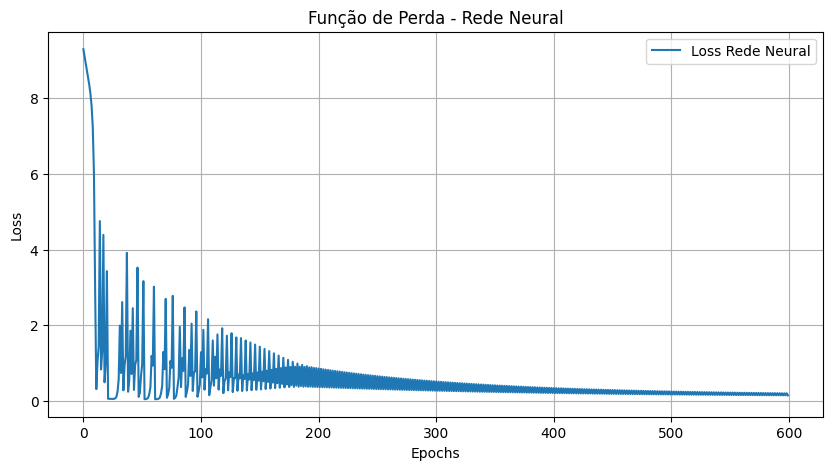

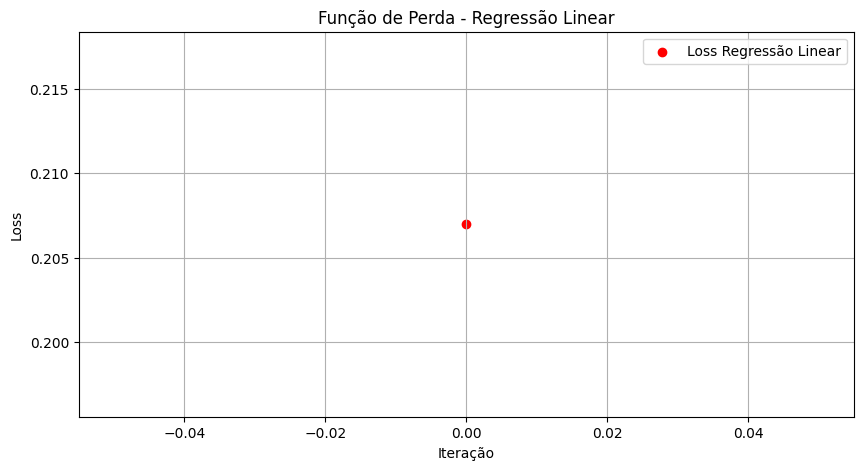

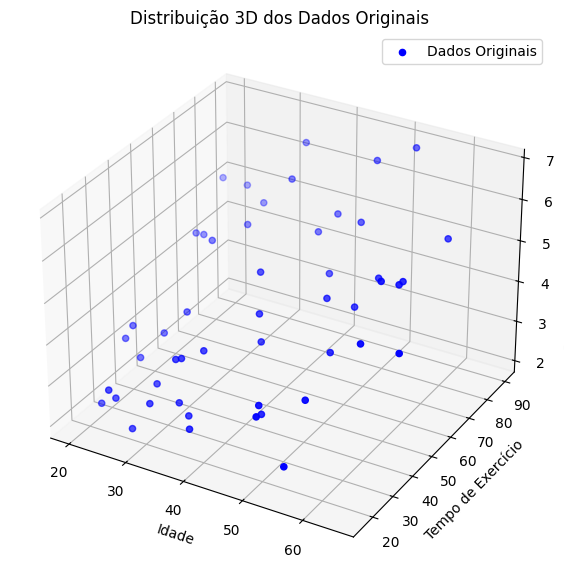

In [6]:
# --- GRÁFICOS ---
# Gráfico da função de perda da rede neural
plt.figure(figsize=(10, 5))
plt.plot(losses_nn, label='Loss Rede Neural')
plt.title('Função de Perda - Rede Neural')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico da função de perda da regressão linear (um único ponto, já que não há epochs)
plt.figure(figsize=(10, 5))
plt.scatter([0], [mse_teste], color='red', label='Loss Regressão Linear')
plt.title('Função de Perda - Regressão Linear')
plt.xlabel('Iteração')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 3D dos dados originais
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dados['Idade'], dados['Tempo de Exercício'], dados['Quantidade de Água (litros)'], c='blue', label='Dados Originais')
ax.set_title('Distribuição 3D dos Dados Originais')
ax.set_xlabel('Idade')
ax.set_ylabel('Tempo de Exercício')
ax.set_zlabel('Quantidade de Água (litros)')
plt.legend()
plt.show()

##6. Gráficos dos dados originais e preditos

Erro Quadrático Médio (MSE) no conjunto de teste (Regressão Linear): 0.2070

Coeficiente de Determinação (R^2) no conjunto de teste (Regressão Linear): 0.8873

Epoch 10, Loss: 2.1271
Epoch 20, Loss: 0.1027
Epoch 30, Loss: 1.5036
Epoch 40, Loss: 0.0510
Epoch 50, Loss: 0.5576
Epoch 60, Loss: 0.2300
Epoch 70, Loss: 2.3749
Epoch 80, Loss: 0.8323
Epoch 90, Loss: 2.6927
Epoch 100, Loss: 1.8670
Erro Quadrático Médio (MSE) no conjunto de teste (Rede Neural): 1.1352

Coeficiente de Determinação (R^2) no conjunto de teste (Rede Neural): 0.3820



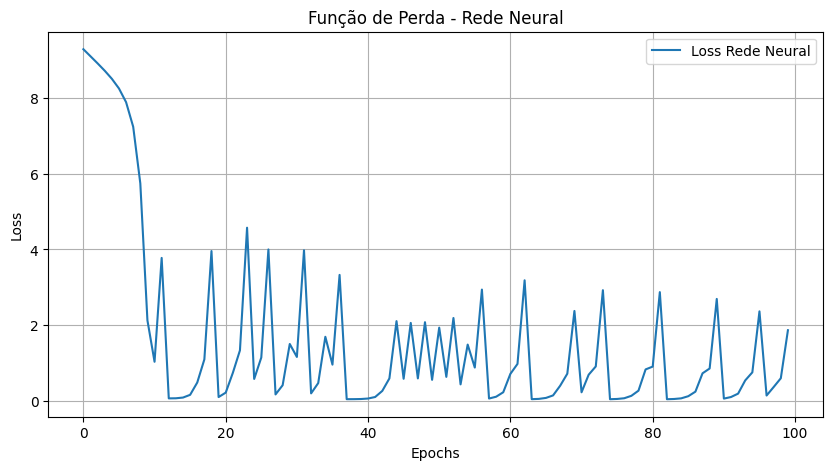

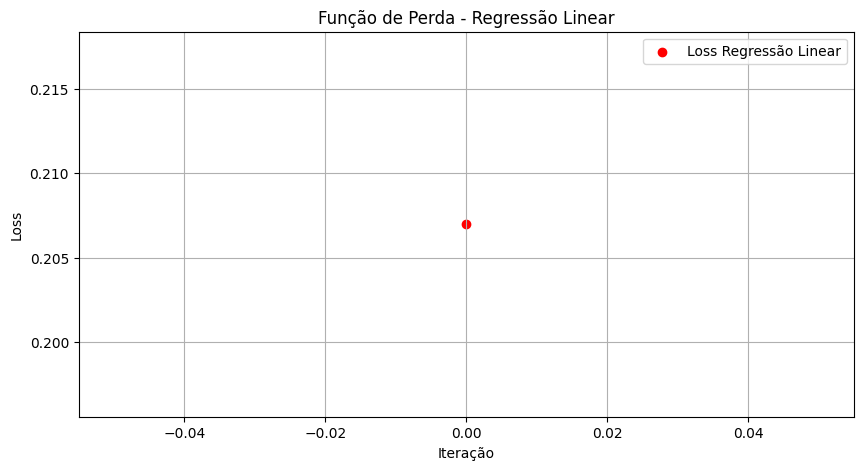

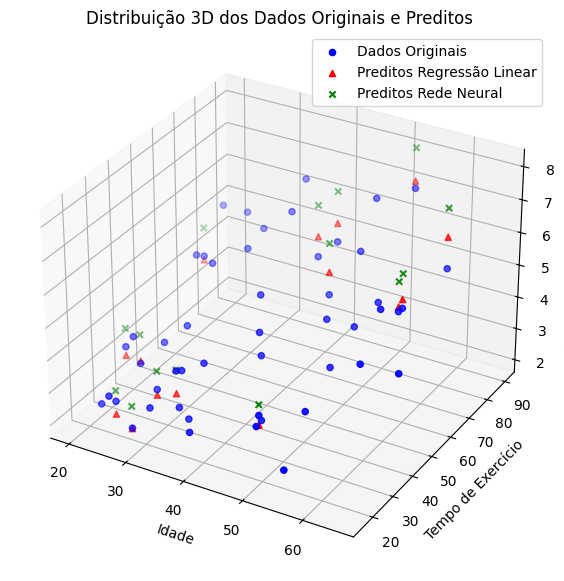

In [7]:
# --- MODELO DE REGRESSÃO LINEAR ---
def regressao_linear(X_treino, y_treino, X_teste, y_teste):
    coeficientes = np.linalg.inv(X_treino.T @ X_treino) @ X_treino.T @ y_treino
    y_pred = X_teste @ coeficientes

    mse = np.mean((y_teste - y_pred)**2)
    ss_total = np.sum((y_teste - np.mean(y_teste))**2)
    ss_residual = np.sum((y_teste - y_pred)**2)
    r2 = 1 - (ss_residual / ss_total)

    return coeficientes, mse, r2, y_pred

coeficientes, mse_teste, r2_teste, y_pred_rl = regressao_linear(X_treino, y_treino, X_teste, y_teste)

print(f"Erro Quadrático Médio (MSE) no conjunto de teste (Regressão Linear): {mse_teste:.4f}\n")
print(f"Coeficiente de Determinação (R^2) no conjunto de teste (Regressão Linear): {r2_teste:.4f}\n")

# --- MODELO DE REDE NEURAL ---
def inicializar_pesos(camadas):
    pesos = {}
    for i in range(len(camadas) - 1):
        pesos[f"W{i+1}"] = np.random.randn(camadas[i], camadas[i+1]) * 0.01
        pesos[f"b{i+1}"] = np.zeros((1, camadas[i+1]))
    return pesos

def relu(Z):
    return np.maximum(0, Z)

def relu_derivada(Z):
    return Z > 0

def forward(X, pesos):
    cache = {"A0": X}
    L = len(pesos) // 2
    for l in range(1, L + 1):
        Z = cache[f"A{l-1}"] @ pesos[f"W{l}"] + pesos[f"b{l}"]
        A = relu(Z) if l < L else Z
        cache[f"Z{l}"] = Z
        cache[f"A{l}"] = A
    return cache

def compute_loss(y, y_pred):
    m = y.shape[0]
    return np.sum((y_pred - y)**2) / (2 * m)

def backward(y, pesos, cache):
    m = y.shape[0]
    L = len(pesos) // 2
    grads = {}

    dZ = cache[f"A{L}"] - y
    for l in reversed(range(1, L + 1)):
        grads[f"dW{l}"] = cache[f"A{l-1}"].T @ dZ / m
        grads[f"db{l}"] = np.sum(dZ, axis=0, keepdims=True) / m
        if l > 1:
            dZ = (dZ @ pesos[f"W{l}"].T) * relu_derivada(cache[f"Z{l-1}"])

    return grads

def atualizar_pesos(pesos, grads, learning_rate):
    L = len(pesos) // 2
    for l in range(1, L + 1):
        pesos[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
        pesos[f"b{l}"] -= learning_rate * grads[f"db{l}"]
    return pesos

def treinar_rede_neural(X, y, camadas, epochs, learning_rate):
    pesos = inicializar_pesos(camadas)
    losses = []
    for epoch in range(epochs):
        cache = forward(X, pesos)
        loss = compute_loss(y, cache[f"A{len(camadas) - 1}"])
        losses.append(loss)
        grads = backward(y, pesos, cache)
        pesos = atualizar_pesos(pesos, grads, learning_rate)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

    return pesos, losses

# Configuração e treinamento da rede neural
camadas = [2, 64, 32, 1]
pesos_nn, losses_nn = treinar_rede_neural(X_treino, y_treino.reshape(-1, 1), camadas, epochs=100, learning_rate=0.01)

# Avaliação no conjunto de teste
def previsao(X, pesos):
    cache = forward(X, pesos)
    return cache[f"A{len(pesos) // 2}"]

y_pred_nn = previsao(X_teste, pesos_nn).flatten()
mse_teste_nn = np.mean((y_teste - y_pred_nn)**2)
ss_total_nn = np.sum((y_teste - np.mean(y_teste))**2)
ss_residual_nn = np.sum((y_teste - y_pred_nn)**2)
r2_teste_nn = 1 - (ss_residual_nn / ss_total_nn)

print(f"Erro Quadrático Médio (MSE) no conjunto de teste (Rede Neural): {mse_teste_nn:.4f}\n")
print(f"Coeficiente de Determinação (R^2) no conjunto de teste (Rede Neural): {r2_teste_nn:.4f}\n")


# --- GRÁFICOS ---
# Gráfico da função de perda da rede neural
plt.figure(figsize=(10, 5))
plt.plot(losses_nn, label='Loss Rede Neural')
plt.title('Função de Perda - Rede Neural')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico da função de perda da regressão linear
plt.figure(figsize=(10, 5))
plt.scatter([0], [mse_teste], color='red', label='Loss Regressão Linear')
plt.title('Função de Perda - Regressão Linear')
plt.xlabel('Iteração')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Gráfico 3D dos dados originais e preditos
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Dados originais
ax.scatter(dados['Idade'], dados['Tempo de Exercício'], dados['Quantidade de Água (litros)'], c='blue', label='Dados Originais')

# Dados preditos pela regressão linear
ax.scatter(teste['Idade'], teste['Tempo de Exercício'], y_pred_rl, c='red', label='Preditos Regressão Linear', marker='^')

# Dados preditos pela rede neural
ax.scatter(teste['Idade'], teste['Tempo de Exercício'], y_pred_nn, c='green', label='Preditos Rede Neural', marker='x')

ax.set_title('Distribuição 3D dos Dados Originais e Preditos')
ax.set_xlabel('Idade')
ax.set_ylabel('Tempo de Exercício')
ax.set_zlabel('Quantidade de Água (litros)')
plt.legend()
plt.show()